<a href="https://colab.research.google.com/github/merrittharlan/SWOT_THP/blob/main/SWOT_GDL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This code explores a preliminary analysis of Surface Water Ocean Topography (SWOT) satellite data products over glacial dammed lakes, using earthaccess. The first cell block includes parameters to change based on a given lake.

Parameters:

* lake_name: name of the lake
* sw_lat, sw_lon: southwest latitude and longitude coordinates respectively, in EPSG 4326
*   ne_lat, ne_lon: northeast latitude and longitude coordinates respectively, in EPSG 4326
* elev_min, elev_max: user defined bounds on a range on lake elevation values to filter between, in meters, for EGM2008 datum
* new_elev_min, new_elev_max: secondary set of user defined bounds on a range on lake elevation values to filter between, in meters, for EGM2008 datum
* start_date: date to begin querying SWOT observation data (nominally set to June 1, 2023
* end_date: date to end querying SWOT observation data (nominally set to the date this script was written, November 19, 2024)
* classification_values: SWOT pixels are classified into seven potential classes, described in further detail here: https://archive.podaac.earthdata.nasa.gov/podaac-ops-cumulus-docs/web-misc/swot_mission_docs/pdd/D-56411_SWOT_Product_Description_L2_HR_PIXC_20240913.pdf :
  * 1: land
  * 2: land near water
  * 3: water near land
  * 4: open water
  * 5: dark water
  * 6: low coherence water nearland
  * 7: open low coherence water
* new_classification: secondary set of user defined classification categories
* geolocation_qual_max: maximum geolocation quality flag value, similarly described in the Product Description Document linked above-- here we choose a value less than 29823 to remove all degraded and bad data (this value was calculated by adding up the bitwise quality values corresponding to the first 11 flags)


In [ ]:
from google.colab import drive
drive.mount('/content/myfiles')

Mounted at /content/myfiles


In [ ]:
%cd "/content/myFiles/MyDrive/SWOT-GDL-Monitoring"
!pwd

[Errno 2] No such file or directory: '/content/myFiles/MyDrive/SWOT-GDL-Monitoring'
/content
/content


In [ ]:
!git clone git@code.chs.usgs.gov:swot-gdl/swot-gdl-monitoring.git

Cloning into 'swot-gdl-monitoring'...
ssh: Could not resolve hostname code.chs.usgs.gov: Name or service not known
fatal: Could not read from remote repository.

Please make sure you have the correct access rights
and the repository exists.


In [ ]:
### up front parameters to change

#lake name
lake_name = 'Snow'

#bounding box of lake
sw_lat, sw_lon = 60.47814, -148.94417
ne_lat, ne_lon = 60.49065, -148.91130

#acceptable range(s) of elevation
elev_min, elev_max = 600, 1300
new_elev_min, new_elev_max = 600, 800

#dates to query data
start_date = '2024-08-01 00:00:00'
end_date = '2024-11-19 00:00:00'

#SWOT classification values
classification_values = [3, 4, 5, 6, 7]
new_classification = [4]

#SWOT geolocation quality
geolocation_qual_max = 29823



Other lakes:

Hidden Lake:
* sw_lat, sw_lon = 61.55011, -143.1302
* ne_lat, ne_lon = 61.56783, -143.0711
* elev_min, elev_max = 800, 1100
* new_elev_min, new_elev_max = 910, 950

Mendenhall
* sw_lat, sw_lon = 58.45336, -134.51044
* ne_lat, ne_lon = 58.46824, -134.47171
* elev_min, elev_max = 400, 900
* new_elev_min, new_elev_max = 580, 670

Nelchina South
* sw_lat, sw_lon = 61.65710, -146.90756
* ne_lat, ne_lon = 61.67268, -146.84551
* elev_min, elev_max = 800, 1500
* new_elev_min, new_elev_max = 1000, 1300

Salmon Tailings
* sw_lat, sw_lon = 56.05973, -130.03677
* ne_lat, ne_lon = 56.07201, -130.02307
* elev_min, elev_max = 0, 600
* new_elev_min, new_elev_max = 250, 400

In [ ]:
import folium

lake_map = folium.Map(location=[(sw_lat + ne_lat) / 2, (sw_lon + ne_lon) / 2], zoom_start=12)

bounding_box = [[sw_lat, sw_lon], [sw_lat, ne_lon], [ne_lat, ne_lon], [ne_lat, sw_lon]]

folium.Polygon(locations=bounding_box, color="blue", weight=2, fill=True, fill_opacity=0.2).add_to(lake_map)

lake_map

Here we use earthaccess to obtain data from SWOT. This requires a login, which you can register for here: https://urs.earthdata.nasa.gov/home.

The first time running this cell block, you will likely need to install earth access, which you can do by uncommenting !pip install earthaccess and running the cell block (then entering your username and password when prompted)

In [ ]:
#!pip install earthaccess
import earthaccess
import xarray as xr

auth = earthaccess.login()

pixc_results = earthaccess.search_data(short_name = 'SWOT_L2_HR_PIXC_2.0',
                                        temporal = (start_date, end_date),
                                        bounding_box = (sw_lon, sw_lat, ne_lon, ne_lat))
len(pixc_results)

34

In [ ]:
import h5py
import numpy as np
import re

def filter_pixc_file(pixc_file, bounding_box,
                     classification_vals = classification_values,
                     geolocation_qual_th = geolocation_qual_max,
                     elev_min = elev_min, elev_max = elev_max):
    """
    Process an SWOT pixel netcdf file, crop data to a bounding box, apply filtering criteria, and return the filtered data.

    Args:
        pixc_file (str): Path to the SWOT pixel netcdf file
        bounding_box (tuple): A tuple of (sw_lon, sw_lat, ne_lon, ne_lat) defining the bounding box for filtering.
        classification_threshold (int): Minimum value for classification to include the data. Default is [3, 4, 5, 6, 7].
        geolocation_qual_threshold (int): Maximum value for geolocation_qual to include the data. Default is 29823.
        elev_min (int): Minimum elevation value to include the data.
        elev_max (int): Maximum elevation value to include the data.

    Returns:
        dict: A dictionary containing the filtered data for 'latitude', 'longitude', 'height',
              'classification', 'geolocation_qual', 'sig0', and 'geoid'.
    """

    # Extract date from the file URL (you may already have this logic elsewhere)
    url = pixc_file.full_name
    date_match = re.search(r'(\d{8})', url)
    date_str = date_match.group(1)

    # Open the HDF5 file
    with h5py.File(pixc_file, 'r') as f:
        # Access the pixel_cloud group
        group = f['pixel_cloud']

        # Get the latitude and longitude arrays
        latitudes = group['latitude'][:]

        # Apply bounding box filter (lat_mask and lon_mask)
        lat_mask = (latitudes >= bounding_box[1]) & (latitudes <= bounding_box[3])

        # If no data within bounding box, return early to avoid loading unnecessary variables
        if not np.any(lat_mask):
            return {
                'latitudes': np.array([]),
                'longitudes': np.array([]),
                'height': np.array([]),
                'elevation': np.array([]),
                'classification': np.array([]),
                'geolocation_qual': np.array([]),
                'sig0': np.array([]),
                'geoid': np.array([]),
                'url': url,
                'date': date_str
            }

        longitudes = group['longitude'][:]
        lon_mask = (longitudes >= bounding_box[0]) & (longitudes <= bounding_box[2])

        # If no data within bounding box, return early to avoid loading unnecessary variables
        if not np.any(lat_mask & lon_mask):
            return {
                'latitudes': np.array([]),
                'longitudes': np.array([]),
                'height': np.array([]),
                'elevation': np.array([]),
                'classification': np.array([]),
                'geolocation_qual': np.array([]),
                'sig0': np.array([]),
                'geoid': np.array([]),
                'url': url,
                'date': date_str
            }

        # Combine lat and lon masks
        combined_mask = lat_mask & lon_mask

        # Load only the necessary variables using the combined mask
        lat_cropped = latitudes[combined_mask]
        lon_cropped = longitudes[combined_mask]

        # Crop the variables that are needed and have data
        height = group['height'][combined_mask]
        classification = group['classification'][combined_mask]
        geolocation_qual = group['geolocation_qual'][combined_mask]
        sig0 = group['sig0'][combined_mask]
        geoid = group['geoid'][combined_mask]

        # Calculate elevation as the sum of height and geoid
        elevation = height - geoid

        # Store the cropped data in a dictionary
        cropped_data = {
            'latitudes': lat_cropped,
            'longitudes': lon_cropped,
            'height': height,
            'classification': classification,
            'geolocation_qual': geolocation_qual,
            'sig0': sig0,
            'geoid': geoid,
            'elevation': elevation,
            'url': url,
            'date': date_str
        }

        # Apply filter conditions for classification, geolocation quality, and elevation
        filter_mask = np.isin(cropped_data['classification'], classification_vals) & \
              (cropped_data['geolocation_qual'] < geolocation_qual_th) & \
              (cropped_data['elevation'] > elev_min) & \
              (cropped_data['elevation'] < elev_max)

          # Apply the filter to all variables in the cropped_data dictionary
        filtered_data = {}

        # Loop through the cropped data to filter each variable
        for key, value in cropped_data.items():
            if isinstance(value, np.ndarray):  # Only apply the filter to numpy arrays
                filtered_data[key] = value[filter_mask]
            else:
                filtered_data[key] = value  # Add non-array items as they are (date, url)

        # Return the filtered data dictionary, including 'date' and 'url'
        return filtered_data

# Example usage:
bounding_box = (sw_lon, sw_lat, ne_lon, ne_lat)
fileset = earthaccess.open(pixc_results[0:1])
filtered_data = filter_pixc_file(fileset[0], bounding_box)

# Example: print filtered height data
print("Filtered height data shape:", filtered_data['height'].shape)

QUEUEING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/1 [00:00<?, ?it/s]

Filtered height data shape: (3701,)


In [ ]:
from concurrent.futures import ThreadPoolExecutor, as_completed
import time

def process_multiple_files_parallel(files, bounding_box,
                                    classification_vals = classification_values,
                                    geolocation_qual_th = geolocation_qual_max,
                                    elev_min = elev_min, elev_max = elev_max):
    """
    Apply the filter_pixc_file function to multiple files concurrently and return a list of filtered data.
    """
    all_filtered_data = []

    # Flatten the files if they are in a list of lists
    flat_files = [file for sublist in files for file in sublist] if isinstance(files[0], list) else files

    start_time = time.time()  # Start timing the process

    # Use ThreadPoolExecutor for parallel execution
    with ThreadPoolExecutor() as executor:
        # Submit each file processing task to the executor
        future_to_file = {executor.submit(filter_pixc_file, file,
                                          bounding_box, classification_vals,
                                          geolocation_qual_th, elev_min, elev_max): file for file in flat_files}

        # Wait for each task to complete and collect results
        for future in as_completed(future_to_file):
            filtered_data = future.result()
            all_filtered_data.append(filtered_data)

    end_time = time.time()  # End timing the process
    elapsed_time = end_time - start_time
    print(f"Processing took {elapsed_time:.2f} seconds.")

    # Count and print how many observations have non-empty data
    non_empty_count = 0
    for data in all_filtered_data:
        if data['height'].size > 0:  # Check if 'height' has data
            non_empty_count += 1

    print(f"Number of files with non-empty data rows: {non_empty_count}")

    return all_filtered_data

Depending on your date range, and the number of files, this next cell block can take a long time-- for reference ~20-60 minutes for 50 files

In [ ]:
# Process all files concurrently
all_pixc_files = [earthaccess.open(pixc_results)]
filtered_data_list = process_multiple_files_parallel(all_pixc_files, bounding_box)

QUEUEING TASKS | :   0%|          | 0/34 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/34 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/34 [00:00<?, ?it/s]

Processing took 1447.20 seconds.
Number of files with non-empty data rows: 21


Here we plot a timeseries of SWOT observations. The pixel cloud data has already been filtered to your bounding box, and based on the initial set of filters, but if you want to change the secondary filters (new_elev_max, new_elev_min, new_classification), you can do so here without rerunning the previous block.

/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:206: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:198: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)
/us

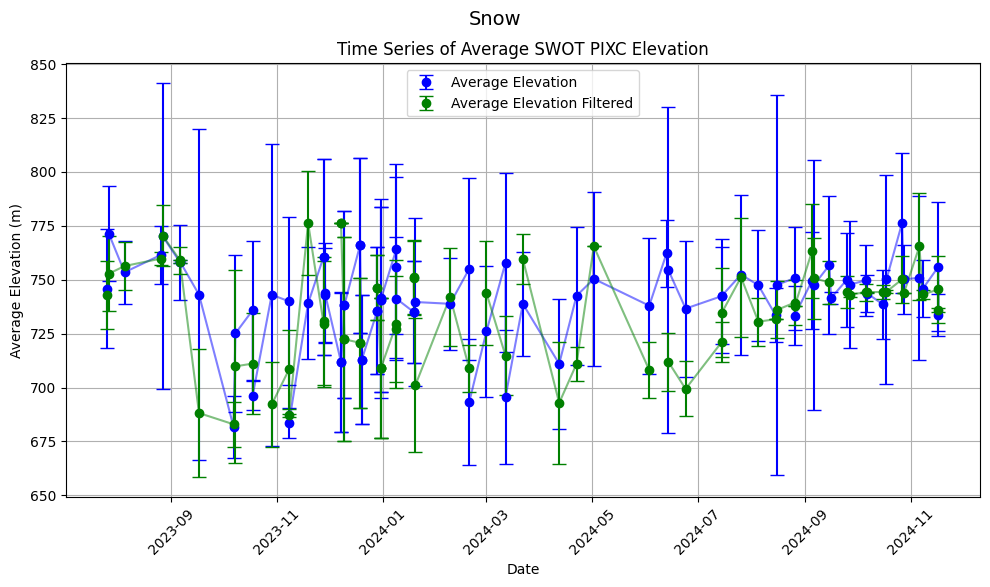

          Date  Average Elevation    Std Dev  Pixel Count  \
3   2023-07-26         745.931091  27.608763         3200   
2   2023-07-27         771.249329  22.021568          226   
6   2023-08-05         753.477051  14.480344         2439   
14  2023-08-26         761.531982  13.605984         2267   
4   2023-08-27         770.256958  70.999817         5119   
..         ...                ...        ...          ...   
164 2024-10-28         750.216492  15.900023          164   
166 2024-11-06         750.904907  38.185463         3249   
169 2024-11-08         745.877014  13.354171         1718   
168 2024-11-17         756.117310  29.867233         2348   
170 2024-11-17         733.741638   9.739698         1708   

     Average Elevation Filtered  Std Dev Filtered  Pixel Count Filtered  \
3                    742.901978         15.898717                   996   
2                    752.854736         17.488106                    18   
6                    756.372925         11

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

def aggregate_data_and_plot(filtered_data_list, new_classification = new_classification, new_elev_min = new_elev_min, new_elev_max = new_elev_max):
    """
    Aggregates data from each file by calculating the average elevation
    and plots a timeseries of average elevation over time with error bars.

    Args:
        filtered_data_list (list): A list of dictionaries containing filtered data from each file.

    Returns:
        pd.DataFrame: A dataframe containing the date and average elevation for each file.
    """
    # Prepare lists to hold dates, average elevations, and standard deviations
    dates = []
    avg_elevations = []
    std_devs = []
    avg_elevations_filtered = []
    std_devs_filtered = []
    obs_ids = []
    obs_count = []
    obs_count_filtered = []

    # Loop through each file's filtered data and extract date, average elevation, and standard deviation
    for data in filtered_data_list:
        date = data['date']
        url = data['url']
        elevation = data['elevation']
        classification = data['classification']

        match = re.search(r'(\d{8})', url)  # Looks for an 8-digit sequence
        if match:
            extracted_date = match.group(1)
            # Extract the 10 characters before the date in the URL
            obs_id = url[max(0, match.start() - 9):match.end()]
        else:
            extracted_date = np.nan
            obs_id = np.nan

        # Filter elevation data based on classification and elevation range for each point
        filter_mask = np.isin(classification, new_classification) & \
              (elevation > new_elev_min) & \
              (elevation < new_elev_max)

        filtered_elevation = elevation[filter_mask]

        # Calculate average and std deviation for unfiltered data
        avg_elevation = np.mean(elevation)
        std_dev = np.std(elevation)

        # Calculate average and std deviation for filtered data
        avg_elevation_filtered = np.mean(filtered_elevation)
        std_dev_filtered = np.std(filtered_elevation)

        # Observation counts
        obs_count.append(len(elevation))  # Unfiltered observation count
        obs_count_filtered.append(len(filtered_elevation))  # Filtered observation count

        # Append data to the lists
        dates.append(date)
        avg_elevations.append(avg_elevation)
        std_devs.append(std_dev)
        avg_elevations_filtered.append(avg_elevation_filtered)
        std_devs_filtered.append(std_dev_filtered)
        obs_ids.append(obs_id)

    # Create a DataFrame to hold the aggregated data

    df = pd.DataFrame({
        'Date': dates,
        'Average Elevation': avg_elevations,
        'Std Dev': std_devs,
        'Pixel Count': obs_count,
        'Average Elevation Filtered': avg_elevations_filtered,
        'Std Dev Filtered': std_devs_filtered,
        'Pixel Count Filtered': obs_count_filtered,
        'Observation ID': obs_ids
    })

    df['Date'] = pd.to_datetime(df['Date'], format='%Y%m%d')
    df = df.dropna(subset=['Average Elevation', 'Std Dev'])

    df = df.sort_values(by='Date')

    # Plot the time series with error bars and a line through the points
    plt.figure(figsize=(10, 6))
    plt.errorbar(df['Date'], df['Average Elevation'], yerr=df['Std Dev'], fmt='o', color='b', label='Average Elevation', capsize=5)
    plt.plot(df['Date'], df['Average Elevation'], color='b', linestyle='-', alpha=0.5)  # Draw a line through the points
    plt.errorbar(df['Date'], df['Average Elevation Filtered'], yerr=df['Std Dev Filtered'], fmt='o', color='g', label='Average Elevation Filtered', capsize=5)
    plt.plot(df['Date'], df['Average Elevation Filtered'], color='g', linestyle='-', alpha=0.5)  # Draw a line through the points
    plt.xlabel('Date')
    plt.ylabel('Average Elevation (m)')
    plt.title('Time Series of Average SWOT PIXC Elevation')
    plt.suptitle(lake_name, fontsize=14, y=0.97)
    plt.grid(True)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.legend()
    plt.show()

    return df

# Aggregate the data and plot the time series
df_avg_elevation = aggregate_data_and_plot(filtered_data_list, new_classification = new_classification, new_elev_min = new_elev_min, new_elev_max = new_elev_max)

# Display the resulting DataFrame
print(df_avg_elevation)


Now we plot a map of elevations for a given observation. Because there might be multiple observations on the same date, we query based on the Observation ID from the table above. Users will need to change the obs_id_of_interest in the bottom line to plot an observation that matches the dataset.

In [ ]:
!pip install pydeck
import pydeck as pdk
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

def plot_map_with_elevation(filtered_data_list, obs_id_of_interest='097_264R_20240601', zoom=12, pitch=40.5, radius=20):
    """
    Plots a map with elevation data using Pydeck based on the provided filtered data list and optional parameters.

    Parameters:
    - filtered_data_list (list): List of data entries containing latitudes, longitudes, and elevation.
    - obs_id_of_interest (str): The observation ID to filter by (default is '097_264R_20240601').
    - zoom (int): Zoom level for the map (default is 12).
    - pitch (float): Pitch angle for the map (default is 40.5).
    - radius (int): The size of the points on the map (default is 20).
    """

    # Step 1: Filter the data based on obs_id
    filtered_data = []
    for entry in filtered_data_list:
        url = entry['url']
        match = re.search(r'(\d{8})', url)
        if match:
            obs_id = url[max(0, match.start() - 9):match.end()]
        else:
            obs_id = np.nan
        entry['obs_id'] = obs_id
        if obs_id_of_interest is None or entry['obs_id'] == obs_id_of_interest:
            filtered_data.append(entry)

    print(f"Filtered Data (Obs ID: {obs_id_of_interest}):", filtered_data)

    # Step 2: Extract latitudes, longitudes, and elevations into lists
    latitudes = filtered_data[0]['latitudes']
    longitudes = filtered_data[0]['longitudes']
    elevations = filtered_data[0]['elevation']
    classifications = filtered_data[0]['classification']
    geolocation_quality = filtered_data[0]['geolocation_qual']




    # Step 3: Prepare a DataFrame for Pydeck
    df = pd.DataFrame({
        'latitude': latitudes,
        'longitude': longitudes,
        'elevation': elevations,
        'classification': classifications,
        'geolocation_quality': geolocation_quality
    })

    print("DataFrame Created:\n", df)

    # Step 4: Normalize the elevation values to the range [0, 1] for colormap
    norm = mcolors.Normalize(vmin=min(elevations), vmax=max(elevations))
    colormap = plt.cm.viridis
    colors = [colormap(norm(elevation)) for elevation in elevations]
    # Convert colors from RGBA to RGB (Pydeck requires RGB format)
    colors_rgb = [[int(c[0] * 255), int(c[1] * 255), int(c[2] * 255)] for c in colors]

    # Add the colors to the DataFrame for Pydeck
    df['color'] = colors_rgb

    # Step 5: Create the Pydeck scatter plot layer
    scatter_layer = pdk.Layer(
        'ScatterplotLayer',
        df,
        get_position='[longitude, latitude]',
        get_radius=radius,  # Size of the points
        get_fill_color='color',  # Color of the points using the Viridis colormap
        get_elevation='elevation',  # Set elevation for each point
        pickable=True,  # Make the points interactive
    )

    # Step 6: Set the initial view of the map (centered on the mean latitude and longitude)
    initial_view = pdk.ViewState(
        latitude=df['latitude'].mean(),
        longitude=df['longitude'].mean(),
        zoom=zoom,
        pitch=pitch
    )

    # Step 7: Create the deck map with the default basemap
    deck = pdk.Deck(
        layers=[scatter_layer],
        initial_view_state=initial_view,
    )

    # Step 8: Display the map
    deck.show()

# Example usage
plot_map_with_elevation(filtered_data_list, obs_id_of_interest='164_047R_20241117', zoom=12, pitch=40.5, radius=20)


Filtered Data (Obs ID: 164_047R_20241117): [{'latitudes': array([60.49035324, 60.49033616, 60.49013211, ..., 60.47856898,
       60.47836004, 60.47819125]), 'longitudes': array([-148.9439816 , -148.94310662, -148.9430581 , ..., -148.9152737 ,
       -148.91619817, -148.91694494]), 'height': array([816.2114 , 813.82904, 813.4273 , ..., 747.8512 , 747.09424,
       748.76654], dtype=float32), 'classification': array([5, 5, 5, ..., 4, 7, 7], dtype=uint8), 'geolocation_qual': array([5, 5, 5, ..., 1, 1, 0], dtype=uint32), 'sig0': array([0.9839805, 1.3000048, 0.6778163, ..., 2.399591 , 2.8426092,
       3.4675958], dtype=float32), 'geoid': array([13.456924, 13.457923, 13.458846, ..., 13.525928, 13.526281,
       13.526564], dtype=float32), 'elevation': array([802.7545 , 800.3711 , 799.96844, ..., 734.32526, 733.56793,
       735.24   ], dtype=float32), 'url': 'https://archive.swot.podaac.earthdata.nasa.gov/podaac-swot-ops-cumulus-protected/SWOT_L2_HR_PIXC_2.0/SWOT_L2_HR_PIXC_024_164_047R_202

<IPython.core.display.Javascript object>

Now we only plot points that passed the second round of filters (new_classification, new_elev_max, new_elev_min).

In [ ]:
import pydeck as pdk
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

def plot_filtered_elevation(filtered_data_list, obs_id_of_interest='097_264R_20240601', zoom=12, pitch=40.5, radius=20):
    """
    Plots a map with elevation data using Pydeck based on the provided filtered data list and optional parameters.

    Parameters:
    - filtered_data_list (list): List of data entries containing latitudes, longitudes, and elevation.
    - obs_id_of_interest (str): The observation ID to filter by (default is '097_264R_20240601').
    - zoom (int): Zoom level for the map (default is 12).
    - pitch (float): Pitch angle for the map (default is 40.5).
    - radius (int): The size of the points on the map (default is 20).
    """

    # Step 1: Filter the data based on obs_id
    filtered_data = []
    for entry in filtered_data_list:
        url = entry['url']
        match = re.search(r'(\d{8})', url)
        if match:
            obs_id = url[max(0, match.start() - 9):match.end()]
        else:
            obs_id = np.nan
        entry['obs_id'] = obs_id
        if obs_id_of_interest is None or entry['obs_id'] == obs_id_of_interest:
            filtered_data.append(entry)

    print(f"Filtered Data (Obs ID: {obs_id_of_interest}):", filtered_data)

    # Step 2: Extract latitudes, longitudes, and elevations into lists
    latitudes = filtered_data[0]['latitudes']
    longitudes = filtered_data[0]['longitudes']
    elevations = filtered_data[0]['elevation']
    classifications = filtered_data[0]['classification']
    geolocation_quality = filtered_data[0]['geolocation_qual']

    filter_mask = np.isin(classifications, new_classification) & \
      (elevations > new_elev_min) & \
      (elevations < new_elev_max)

    # Step 3: Prepare a DataFrame for Pydeck
    df = pd.DataFrame({
        'latitude': latitudes[filter_mask],
        'longitude': longitudes[filter_mask],
        'elevation': elevations[filter_mask],
        'classification': classifications[filter_mask],
        'geolocation_quality': geolocation_quality[filter_mask]
    })

    print("DataFrame Created:\n", df)

    # Step 4: Normalize the elevation values to the range [0, 1] for colormap
    norm = mcolors.Normalize(vmin=min(elevations[filter_mask]), vmax=max(elevations[filter_mask]))
    colormap = plt.cm.viridis
    colors = [colormap(norm(elevation)) for elevation in elevations[filter_mask]]
    # Convert colors from RGBA to RGB (Pydeck requires RGB format)
    colors_rgb = [[int(c[0] * 255), int(c[1] * 255), int(c[2] * 255)] for c in colors]

    # Add the colors to the DataFrame for Pydeck
    df['color'] = colors_rgb

    # Step 5: Create the Pydeck scatter plot layer
    scatter_layer = pdk.Layer(
        'ScatterplotLayer',
        df,
        get_position='[longitude, latitude]',
        get_radius=radius,  # Size of the points
        get_fill_color='color',  # Color of the points using the Viridis colormap
        get_elevation='elevation',  # Set elevation for each point
        pickable=True,  # Make the points interactive
    )

    # Step 6: Set the initial view of the map (centered on the mean latitude and longitude)
    initial_view = pdk.ViewState(
        latitude=df['latitude'].mean(),
        longitude=df['longitude'].mean(),
        zoom=zoom,
        pitch=pitch
    )

    # Step 7: Create the deck map with the default basemap
    deck = pdk.Deck(
        layers=[scatter_layer],
        initial_view_state=initial_view,
    )

    # Step 8: Display the map
    deck.show()

# Example usage
plot_filtered_elevation(filtered_data_list, obs_id_of_interest='164_047R_20241117', zoom=12, pitch=40.5, radius=20)


Filtered Data (Obs ID: 164_047R_20241117): [{'latitudes': array([60.49035324, 60.49033616, 60.49013211, ..., 60.47856898,
       60.47836004, 60.47819125]), 'longitudes': array([-148.9439816 , -148.94310662, -148.9430581 , ..., -148.9152737 ,
       -148.91619817, -148.91694494]), 'height': array([816.2114 , 813.82904, 813.4273 , ..., 747.8512 , 747.09424,
       748.76654], dtype=float32), 'classification': array([5, 5, 5, ..., 4, 7, 7], dtype=uint8), 'geolocation_qual': array([5, 5, 5, ..., 1, 1, 0], dtype=uint32), 'sig0': array([0.9839805, 1.3000048, 0.6778163, ..., 2.399591 , 2.8426092,
       3.4675958], dtype=float32), 'geoid': array([13.456924, 13.457923, 13.458846, ..., 13.525928, 13.526281,
       13.526564], dtype=float32), 'elevation': array([802.7545 , 800.3711 , 799.96844, ..., 734.32526, 733.56793,
       735.24   ], dtype=float32), 'url': 'https://archive.swot.podaac.earthdata.nasa.gov/podaac-swot-ops-cumulus-protected/SWOT_L2_HR_PIXC_2.0/SWOT_L2_HR_PIXC_024_164_047R_202

<IPython.core.display.Javascript object>